# Training species classifier Expt 3: cross-validation of Oswald data
# Effort to train the classifier
# Feb 17, 2021
## Trained on PICEAS2005 & STAR2000 whereas tested on HICEAS2002, STAR2003 & STAR2006


In [1]:
import numpy as np
from itertools import permutations
import random
import os
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import pandas as pd
from os import makedirs
from datetime import datetime
from collections import Counter

from math import floor

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report

# from MulticoreTSNE import MulticoreTSNE as TSNE
# from sklearn.manifold import TSNE
import seaborn as sns

from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Activation
from tensorflow.keras.layers import Conv2D, Lambda, Flatten, MaxPooling2D, Concatenate, LSTM, Reshape, Lambda, ConvLSTM2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import Bidirectional, LSTM, GRU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K

from tensorflow.keras.optimizers.schedules import ExponentialDecay, PiecewiseConstantDecay
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.losses import binary_crossentropy, CategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
# import tensorflow_addons as tfa
# import tensorflow_datasets as tfds
from tensorflow.math import l2_normalize

import tensorflow as tf

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
# Hyper parameters
learning_rate = 3.33e-4
conv_dim = 16
rnn_dim = 16
pool_size = 2
pool_stride = 2
l2_regu = 0.000
drop_rate = 0.2
hidden_units = 512
fcn_dim = 512

# learning_rate = 1.e-4
# conv_dim = 64
# rnn_dim = 16
# pool_size = 2
# pool_stride = 2
# l2_regu = 0.00
# drop_rate = 0.2
# # drop_rate = 0.5
# hidden_units = 512
# fcn_dim = 512

num_epoch = 200
# batch_size = 128
batch_size = 32  # for cnn14+attention

num_patience = 5

In [4]:
# data_type_dict = {1: 'universal', 2: 'file', 3: 'encounter', 4: 'domain'}
# data_type = 2

work_path = '/home/ys587/__Data/__whistle/__whislte_30_species'
fit_result_path =  os.path.join(work_path, '__fit_result_species')
# feature_path = os.path.join(work_path, '__feature_species')
feature_path = os.path.join(work_path, '__dataset/20210210')

In [5]:
species_dict = {'BD': 0, 'CD': 1, 'STR': 2, 'SPT': 3, 'SPIN': 4, 'PLT': 5, 'RT': 6,  'FKW': 7}
num_species = len(species_dict)
# species_dict = {'BD': 0, 'MH': 1, 'CD': 2, 'STR': 3, 'SPT': 4, 'SPIN': 5, 'PLT': 6, 'RD': 7, 'RT': 8,
#                 'WSD': 9, 'FKW': 10, 'BEL': 11, 'KW': 12, 'WBD': 13, 'DUSK': 14, 'FRA': 15, 'PKW': 16, 'LPLT': 17,
#                 'CLY': 18, 'SPE': 19, 'ASP': 20}
species_list = list(species_dict.keys())
species_id = list(species_dict.values())

## Combine features

In [6]:
deployment = ['STAR2000', 'STAR2003', 'STAR2006', 'HICEAS2002', 'PICEAS2005']  # oswald_STAR2000_orig.npz, oswald_STAR2000_aug.npz
feature_path = '/home/ys587/__Data/__whistle/__whislte_30_species/__dataset/20210216_augment_all_three'

In [7]:
if False:
    for ee in deployment:
        print(ee)
        ee_others = [ee2 for ee2 in deployment if (ee2 != ee) ]
        fea_train_files_tot = []
        for ee2 in ee_others:
            fea_train_files_tot.append('oswald_'+ee2+'_orig.npz')
            fea_train_files_tot.append('oswald_'+ee2+'_aug.npz')

        # Training data
        fea_train_list = []
        label_train_list = []
        for ii in range(len(fea_train_files_tot)):
            ff = fea_train_files_tot[ii]
            print(ff)
            fea_temp = np.load(os.path.join(feature_path, ff))
            print(fea_temp.files)

            if ii == 0:
                fea_train = fea_temp['feas_orig']
                label_train = fea_temp['labels_orig']
                print(fea_train.shape)
                print(label_train.shape)
            elif ii % 2 == 0:  # even
                fea_train = np.concatenate([fea_train, fea_temp['feas_orig']])
                label_train = np.concatenate([label_train, fea_temp['labels_orig']])
                print(fea_train.shape)
                print(label_train.shape)
            else:
                fea_train = np.concatenate([fea_train, fea_temp['feas_aug']])
                label_train = np.concatenate([label_train, fea_temp['labels_aug']])
                print(fea_train.shape)
                print(label_train.shape)
        print(fea_train.shape)
        print(label_train.shape)
        np.savez(os.path.join(feature_path, './train_oswald_no_'+ee+'.npz'), fea_train=fea_train, label_train=label_train)
        print('')

In [8]:
# data generator
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, feature, label, batch_size=32, num_classes=None, shuffle=True):
        self.batch_size = batch_size
        self.X = feature
        self.X_dim = len(feature.shape)
        self.y = to_categorical(label, num_classes)
        self.indices = np.arange(self.y.shape[0])
        self.num_classes = num_classes
        self.shuffle = shuffle
        
        # self.index = np.arange(len(self.indices))
        #self.df = dataframe
        #self.indices = self.df.index.tolist()        
        # self.x_col = x_col
        # self.y_col = y_col
        
        self.on_epoch_end()

    def __len__(self):
        return int(floor(len(self.indices)/self.batch_size))
        # return label.shape[0]

    def __getitem__(self, index):
        # index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
        # batch = [self.indices[k] for k in index]
        batch = list(range(index*self.batch_size, (index+1)*self.batch_size))
        
        X, y = self.__get_data(batch)
        return X, y

    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.indices)

    def __get_data(self, batch):
        y = np.zeros((self.batch_size, self.y.shape[1]))
        
        if self.X_dim == 3:
            X = np.zeros((self.batch_size, self.X.shape[1], self.X.shape[2]))
            for i, id in enumerate(batch):
                X[i,:, :] = self.X[id, :, :]  # logic
                y[i, :] = self.y[id, :] # labels
                
        elif self.X_dim == 4:
            X = np.zeros((self.batch_size, self.X.shape[1], self.X.shape[2], self.X.shape[3]))
            for i, id in enumerate(batch):
                X[i,:, :, :] = self.X[id, :, :, :]  # logic
                y[i, :] = self.y[id, :] # labels

        return X, y

## Models

In [9]:
# Kong's attention
# def max_pooling(inputs, **kwargs):
#     input = inputs[0]   # (batch_size, time_steps, freq_bins)
#     return K.max(input, axis=1)
def max_pooling(inputs, **kwargs):
    # input = inputs[0]   # (batch_size, time_steps, freq_bins)
    return K.max(inputs, axis=1)


def average_pooling(inputs, **kwargs):
    input = inputs[0]   # (batch_size, time_steps, freq_bins)
    return K.mean(input, axis=1)


def attention_pooling(inputs, **kwargs):
    [out, att] = inputs

    epsilon = 1e-7
    att = K.clip(att, epsilon, 1. - epsilon)
    normalized_att = att / K.sum(att, axis=1)[:, None, :]

    return K.sum(out * normalized_att, axis=1)


def pooling_shape(input_shape):

    if isinstance(input_shape, list):
        (sample_num, time_steps, freq_bins) = input_shape[0]

    else:
        (sample_num, time_steps, freq_bins) = input_shape

    return (sample_num, freq_bins)

In [10]:
# cnn14 attention with customized maxpooling
def model_cnn14_attention_multi(time_steps, freq_bins, classes_num, model_type='feature_level_attention', conv_dim=64, rnn_dim=128, pool_size=2, pool_stride=2, hidden_units=512, l2_regu=0., drop_rate=0., multilabel=True):
    # Kong's attention
    # model_type = 'decision_level_max_pooling'  # problem with dimensions of the Lambda layer after training
    # model_type = 'decision_level_average_pooling' # problem with dimensions of the Lambda layer after training
    # model_type = 'decision_level_single_attention'
    # model_type = 'decision_level_multi_attention'
    # model_type = 'feature_level_attention'

    input_layer = Input(shape=(time_steps, freq_bins, 1), name='input')
    # group 1
    y = Conv2D(conv_dim, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(input_layer)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = Conv2D(conv_dim, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = MaxPooling2D(pool_size=(pool_size, 2), strides=(pool_stride, 2), padding='same')(y)
    y = Dropout(drop_rate)(y)
    
    # group 2
    y = Conv2D(conv_dim*2, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = Conv2D(conv_dim*2, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = MaxPooling2D(pool_size=(pool_size, 2), strides=(pool_stride, 2), padding='same')(y)
    y = Dropout(drop_rate)(y)
    
    # group 3
    y = Conv2D(conv_dim*4, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = Conv2D(conv_dim*4, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = MaxPooling2D(pool_size=(pool_size, 2), strides=(pool_stride, 2), padding='same')(y)
    y = Dropout(drop_rate)(y)
    
    # group 4 
    y = Conv2D(conv_dim*8, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = Conv2D(conv_dim*8, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = MaxPooling2D(pool_size=(pool_size, 2), strides=(pool_stride, 2), padding='same')(y)
    y = Dropout(drop_rate)(y)

    # group 5
    y = Conv2D(conv_dim*16, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = Conv2D(conv_dim*16, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = MaxPooling2D(pool_size=(pool_size, 2), strides=(1, 2), padding='same')(y)
    y = Dropout(drop_rate)(y)

    # group 6
    y = Conv2D(conv_dim*32, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = Conv2D(conv_dim*32, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = MaxPooling2D(pool_size=(pool_size, 2), strides=(1, 2), padding='same')(y)
    y = Dropout(drop_rate)(y)
    
    # change dimensions: samples, time, frequency, channels => samples, time, frequency*channels
    dim_cnn = K.int_shape(y)
    y = Reshape((dim_cnn[1], dim_cnn[2]*dim_cnn[3]))(y)

    a1 = Dense(hidden_units)(y)
    a1 = BatchNormalization()(a1)
    a1 = Activation('relu')(a1)
    a1 = Dropout(drop_rate)(a1)

    a2 = Dense(hidden_units)(a1)
    a2 = BatchNormalization()(a2)
    a2 = Activation('relu')(a2)
    a2 = Dropout(drop_rate)(a2)

    a3 = Dense(hidden_units)(a2)
    a3 = BatchNormalization()(a3)
    a3 = Activation('relu')(a3)
    a3 = Dropout(drop_rate)(a3)

    # Pooling layers
    if model_type == 'decision_level_max_pooling':
        '''Global max pooling.

        [1] Choi, Keunwoo, et al. "Automatic tagging using deep convolutional 
        neural networks." arXiv preprint arXiv:1606.00298 (2016).
        '''
        cla = Dense(classes_num, activation='sigmoid')(a3)
        
        # output_layer = Lambda(
        #    max_pooling, 
        #    output_shape=pooling_shape)(
        #    [cla])
        output_layer = Lambda(max_pooling)(cla)

    elif model_type == 'decision_level_average_pooling':
        '''Global average pooling.

        [2] Lin, Min, et al. Qiang Chen, and Shuicheng Yan. "Network in 
        network." arXiv preprint arXiv:1312.4400 (2013).
        '''
        cla = Dense(classes_num, activation='sigmoid')(a3)
        # output_layer = Lambda(
        #    average_pooling,
        #    output_shape=pooling_shape)(
        #    [cla])
        output_layer = Lambda(average_pooling)(cla)

    elif model_type == 'decision_level_single_attention':
        '''Decision level single attention pooling.
        [3] Kong, Qiuqiang, et al. "Audio Set classification with attention
        model: A probabilistic perspective." arXiv preprint arXiv:1711.00927
        (2017).
        '''
        cla = Dense(classes_num, activation='sigmoid')(a3)
        att = Dense(classes_num, activation='softmax')(a3)
        output_layer = Lambda(
            attention_pooling, output_shape=pooling_shape)([cla, att])

    elif model_type == 'decision_level_multi_attention':
        '''Decision level multi attention pooling.
        [4] Yu, Changsong, et al. "Multi-level Attention Model for Weakly
        Supervised Audio Classification." arXiv preprint arXiv:1803.02353
        (2018).
        '''
        cla1 = Dense(classes_num, activation='sigmoid')(a2)
        att1 = Dense(classes_num, activation='softmax')(a2)
        out1 = Lambda(
            attention_pooling, output_shape=pooling_shape)([cla1, att1])

        cla2 = Dense(classes_num, activation='sigmoid')(a3)
        att2 = Dense(classes_num, activation='softmax')(a3)
        out2 = Lambda(
            attention_pooling, output_shape=pooling_shape)([cla2, att2])

        b1 = Concatenate(axis=-1)([out1, out2])
        b1 = Dense(classes_num)(b1)
        
        if multilabel:
            output_layer = Activation('sigmoid')(b1)
        else:
            output_layer = Activation('softmax')(b1)

    elif model_type == 'feature_level_attention':
        '''Feature level attention.
        [1] Kong, Qiuqiang, et al. "Weakly labelled audioset tagging with 
        attention neural networks." (2019).
        '''
        cla = Dense(hidden_units, activation='linear')(a3)
        att = Dense(hidden_units, activation='sigmoid')(a3)
        b1 = Lambda(
            attention_pooling, output_shape=pooling_shape)([cla, att])

        b1 = BatchNormalization()(b1)
        b1 = Activation(activation='relu')(b1)
        b1 = Dropout(drop_rate)(b1)
        
        if multilabel:
            output_layer = Dense(classes_num, activation='sigmoid')(b1)
        else:
            output_layer = Dense(classes_num, activation='softmax')(b1)

    else:
        raise Exception("Incorrect model_type!")

    # Build model
    model = Model(inputs=input_layer, outputs=output_layer)
    
    return model

In [11]:
# cnn14 attention
def model_cnn14_attention(time_steps, freq_bins, classes_num, model_type='feature_level_attention', conv_dim=64, rnn_dim=128, pool_size=2, pool_stride=2, hidden_units=512, l2_regu=0., drop_rate=0., multilabel=True):
    # Kong's attention
    # model_type = 'decision_level_max_pooling'  # problem with dimensions of the Lambda layer after training
    # model_type = 'decision_level_average_pooling' # problem with dimensions of the Lambda layer after training
    # model_type = 'decision_level_single_attention'
    # model_type = 'decision_level_multi_attention'
    # model_type = 'feature_level_attention'

    input_layer = Input(shape=(time_steps, freq_bins, 1), name='input')
    # group 1
    y = Conv2D(conv_dim, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(input_layer)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = Conv2D(conv_dim, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = MaxPooling2D(pool_size=(pool_size, 2), strides=(pool_stride, 2), padding='same')(y)
    y = Dropout(drop_rate)(y)
    
    # group 2
    y = Conv2D(conv_dim*2, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = Conv2D(conv_dim*2, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = MaxPooling2D(pool_size=(pool_size, 2), strides=(pool_stride, 2), padding='same')(y)
    y = Dropout(drop_rate)(y)
    
    # group 3
    y = Conv2D(conv_dim*4, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = Conv2D(conv_dim*4, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = MaxPooling2D(pool_size=(pool_size, 2), strides=(pool_stride, 2), padding='same')(y)
    y = Dropout(drop_rate)(y)
    
    # group 4 
    y = Conv2D(conv_dim*8, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = Conv2D(conv_dim*8, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = MaxPooling2D(pool_size=(pool_size, 2), strides=(pool_stride, 2), padding='same')(y)
    y = Dropout(drop_rate)(y)

    # group 5
    y = Conv2D(conv_dim*16, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = Conv2D(conv_dim*16, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = MaxPooling2D(pool_size=(pool_size, 2), strides=(pool_stride, 2), padding='same')(y)
    y = Dropout(drop_rate)(y)

    # group 6
    y = Conv2D(conv_dim*32, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = Conv2D(conv_dim*32, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = MaxPooling2D(pool_size=(pool_size, 2), strides=(pool_stride, 2), padding='same')(y)
    y = Dropout(drop_rate)(y)
    
    # change dimensions: samples, time, frequency, channels => samples, time, frequency*channels
    dim_cnn = K.int_shape(y)
    y = Reshape((dim_cnn[1], dim_cnn[2]*dim_cnn[3]))(y)

    a1 = Dense(hidden_units)(y)
    a1 = BatchNormalization()(a1)
    a1 = Activation('relu')(a1)
    a1 = Dropout(drop_rate)(a1)

    a2 = Dense(hidden_units)(a1)
    a2 = BatchNormalization()(a2)
    a2 = Activation('relu')(a2)
    a2 = Dropout(drop_rate)(a2)

    a3 = Dense(hidden_units)(a2)
    a3 = BatchNormalization()(a3)
    a3 = Activation('relu')(a3)
    a3 = Dropout(drop_rate)(a3)

    # Pooling layers
    if model_type == 'decision_level_max_pooling':
        '''Global max pooling.

        [1] Choi, Keunwoo, et al. "Automatic tagging using deep convolutional 
        neural networks." arXiv preprint arXiv:1606.00298 (2016).
        '''
        cla = Dense(classes_num, activation='sigmoid')(a3)
        
        # output_layer = Lambda(
        #    max_pooling, 
        #    output_shape=pooling_shape)(
        #    [cla])
        output_layer = Lambda(max_pooling)(cla)

    elif model_type == 'decision_level_average_pooling':
        '''Global average pooling.

        [2] Lin, Min, et al. Qiang Chen, and Shuicheng Yan. "Network in 
        network." arXiv preprint arXiv:1312.4400 (2013).
        '''
        cla = Dense(classes_num, activation='sigmoid')(a3)
        # output_layer = Lambda(
        #    average_pooling,
        #    output_shape=pooling_shape)(
        #    [cla])
        output_layer = Lambda(average_pooling)(cla)

    elif model_type == 'decision_level_single_attention':
        '''Decision level single attention pooling.
        [3] Kong, Qiuqiang, et al. "Audio Set classification with attention
        model: A probabilistic perspective." arXiv preprint arXiv:1711.00927
        (2017).
        '''
        cla = Dense(classes_num, activation='sigmoid')(a3)
        att = Dense(classes_num, activation='softmax')(a3)
        output_layer = Lambda(
            attention_pooling, output_shape=pooling_shape)([cla, att])

    elif model_type == 'decision_level_multi_attention':
        '''Decision level multi attention pooling.
        [4] Yu, Changsong, et al. "Multi-level Attention Model for Weakly
        Supervised Audio Classification." arXiv preprint arXiv:1803.02353
        (2018).
        '''
        cla1 = Dense(classes_num, activation='sigmoid')(a2)
        att1 = Dense(classes_num, activation='softmax')(a2)
        out1 = Lambda(
            attention_pooling, output_shape=pooling_shape)([cla1, att1])

        cla2 = Dense(classes_num, activation='sigmoid')(a3)
        att2 = Dense(classes_num, activation='softmax')(a3)
        out2 = Lambda(
            attention_pooling, output_shape=pooling_shape)([cla2, att2])

        b1 = Concatenate(axis=-1)([out1, out2])
        b1 = Dense(classes_num)(b1)
        
        if multilabel:
            output_layer = Activation('sigmoid')(b1)
        else:
            output_layer = Activation('softmax')(b1)

    elif model_type == 'feature_level_attention':
        '''Feature level attention.
        [1] Kong, Qiuqiang, et al. "Weakly labelled audioset tagging with 
        attention neural networks." (2019).
        '''
        cla = Dense(hidden_units, activation='linear')(a3)
        att = Dense(hidden_units, activation='sigmoid')(a3)
        b1 = Lambda(
            attention_pooling, output_shape=pooling_shape)([cla, att])

        b1 = BatchNormalization()(b1)
        b1 = Activation(activation='relu')(b1)
        b1 = Dropout(drop_rate)(b1)
        
        if multilabel:
            output_layer = Dense(classes_num, activation='sigmoid')(b1)
        else:
            output_layer = Dense(classes_num, activation='softmax')(b1)

    else:
        raise Exception("Incorrect model_type!")

    # Build model
    model = Model(inputs=input_layer, outputs=output_layer)
    
    return model

In [12]:
def model_cnn14(time_steps, freq_bins, classes_num, pool_size=2, pool_stride=2, conv_dim=16, fcn_dim=512, l2_regu=0., drop_rate=0.):
    # input
    input_layer = Input(shape=(time_steps, freq_bins, 1), name='input')
    
    # group 1
    y = Conv2D(conv_dim, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(input_layer)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = Conv2D(conv_dim, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(y)
    y = Dropout(drop_rate)(y)
    
    # group 2
    y = Conv2D(conv_dim*2, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = Conv2D(conv_dim*2, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(y)
    y = Dropout(drop_rate)(y)
    
    # group 3
    y = Conv2D(conv_dim*4, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = Conv2D(conv_dim*4, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(y)
    y = Dropout(drop_rate)(y)
    
    # group 4 
    y = Conv2D(conv_dim*8, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = Conv2D(conv_dim*8, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(y)
    y = Dropout(drop_rate)(y)

    # group 5
    y = Conv2D(conv_dim*16, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = Conv2D(conv_dim*16, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(y)
    y = Dropout(drop_rate)(y)

    # group 6
    y = Conv2D(conv_dim*32, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = Conv2D(conv_dim*32, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    
    y = GlobalMaxPooling2D()(y)
    
    # FC block
    y = Dense(fcn_dim, activation='relu', name='cnn14_fcn')(y)  # original 512
    x = Dense(classes_num, activation='softmax')(y)
    
    # Build model
    model = Model(inputs=input_layer, outputs=x)
    
    return model

# Model compile, class weight & fitting

In [13]:
# def find_best_model(model_folder, remove_others=False):
#     model_list = glob.glob(model_folder+'/*.hdf5')
#     model_list.sort()
#     the_best_model = model_list[-1]
    
#     if remove_others==True:
#         for mm in model_list[:-1]:
#             os.remove(mm)
            
#     print(the_best_model)
    
#     return the_best_model
import re

def find_best_model(classifier_path, fmt='epoch_\d+_valloss_(\d+.\d{4})_valacc_\d+.\d{4}.hdf5', is_max=False, purge=True):
    """
    Return the path to the model with the best accuracy, given the path to
    all the trained classifiers
    Args:
        classifier_path: path to all the trained classifiers
        fmt: e.g. "epoch_\d+_[0-1].\d+_(\d+.\d{4}).hdf5"
        'epoch_\d+_valloss_(\d+.\d{4})_valacc_\d+.\d{4}.hdf5'
        is_max: use max; otherwise, min
        purge: True to purge models files except the best one
    Return:
        the path of the model with the best accuracy
    """
    # list all files ending with .hdf5
    day_list = sorted(glob.glob(os.path.join(classifier_path + '/', '*.hdf5')))

    # re the last 4 digits for accuracy
    hdf5_filename = []
    hdf5_accu = np.zeros(len(day_list))
    for dd in range(len(day_list)):
        filename = os.path.basename(day_list[dd])
        hdf5_filename.append(filename)
        # m = re.search("_F1_(0.\d{4}).hdf5", filename)
        # m = re.search("_([0-1].\d{4}).hdf5", filename)
        # m = re.search("epoch_\d+_[0-1].\d+_(\d+.\d{4}).hdf5", filename)
        m = re.search(fmt, filename)
        try:
            hdf5_accu[dd] = float(m.groups()[0])
        except:
            continue

    # select the laregest one and write to the variable classifier_file
    if len(hdf5_accu) == 0:
        best_model_path = ''
        best_accu = 0
    else:
        if is_max is True:
            ind_max = np.argmax(hdf5_accu)
        else: # use min instead
            ind_max = np.argmin(hdf5_accu)
        best_model_path = day_list[int(ind_max)]
        best_accu = hdf5_accu[ind_max]
        # purge all model files except the best_model
        if purge:
            for ff in day_list:
                if ff != best_model_path:
                    os.remove(ff)
    print('Best model:'+str(best_accu))
    print(best_model_path)
    return best_model_path, best_accu


In [14]:
### cnn4 + attention
# model = model_cnn_attention(dim_time, dim_freq, num_species, model_type='decision_level_max_pooling', conv_dim=conv_dim, l2_regu=l2_regu, drop_rate=drop_rate)
# model = model_cnn_attention(dim_time, dim_freq, num_species, model_type='decision_level_multi_attention', conv_dim=conv_dim, l2_regu=l2_regu, drop_rate=drop_rate)
# model = model_cnn_attention(dim_time, dim_freq, num_species, model_type='feature_level_attention', conv_dim=conv_dim, l2_regu=l2_regu, drop_rate=drop_rate)

# vggish
# model = model_vggish(dim_time, dim_freq, num_species, conv_dim=conv_dim, fcn_dim=fcn_dim)

# cnn10
# model = model_cnn10(dim_time, dim_freq, num_species, conv_dim=conv_dim, fcn_dim=fcn_dim, l2_regu=l2_regu, drop_rate=drop_rate)

# cnn14
# model = model_cnn14(dim_time, dim_freq, num_species, conv_dim=conv_dim, fcn_dim=fcn_dim, l2_regu=l2_regu, drop_rate=drop_rate)

# cnn14 attention
# model = model_cnn14_attention(dim_time, dim_freq, num_species, model_type='feature_level_attention', conv_dim=conv_dim, pool_size=pool_size, pool_stride=pool_stride, hidden_units=hidden_units, l2_regu=l2_regu, drop_rate=drop_rate)
# model = model_cnn14_bigru_attention(dim_time, dim_freq, num_species, model_type='feature_level_attention', conv_dim=conv_dim, rnn_dim=rnn_dim, hidden_units=hidden_units, l2_regu=l2_regu, drop_rate=drop_rate)

# model = model_cnn14_attention_multi(dim_time, dim_freq, num_species, model_type='feature_level_attention', conv_dim=conv_dim, pool_size=pool_size, pool_stride=pool_stride, hidden_units=hidden_units, l2_regu=l2_regu, drop_rate=drop_rate)
# loss = CategoricalCrossentropy()
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss=loss, metrics=['accuracy'])



In [15]:
boundaries = [15, 30, 45, 60]
values = [1.0e-3, 3.33e-4, 1.0e-4, 3.33e-5, 1.0e-5]
learning_rate_fn = PiecewiseConstantDecay(boundaries, values)

# Cross validation

In [16]:
today = datetime.now()
# create a folder based on date & time
fit_result_path1 = os.path.join(fit_result_path, today.strftime('%Y%m%d_%H%M%S'))

## STAR2000

In [17]:
ee = deployment[0]
print(ee)

STAR2000


In [18]:
# Training data
fea_temp = np.load(os.path.join(feature_path, 'train_oswald_no_'+ee+'.npz'))
fea_train = fea_temp['fea_train']
label_train_list = fea_temp['label_train']
del fea_temp

In [19]:
label_train = np.zeros(len(label_train_list))
for ii in range(len(label_train_list)):
    label_train[ii] = species_dict[label_train_list[ii]]

In [20]:
# Testing data
fea_temp = np.load(os.path.join(feature_path, 'oswald_'+ee+'_orig.npz'))
fea_test = fea_temp['feas_orig']
label_test_list = fea_temp['labels_orig']

fea_test = fea_test[:,:100,:]
label_test = np.zeros(len(label_test_list))
for ii in range(len(label_test_list)):
    label_test[ii] = species_dict[label_test_list[ii]]

In [21]:
fea_train = fea_train[:,:100,:]

In [22]:
label_train = np.zeros(len(label_train_list))
for ii in range(len(label_train_list)):
    label_train[ii] = species_dict[label_train_list[ii]]

In [23]:
Counter(label_train_list)

Counter({'BD': 10740,
         'CD': 4656,
         'FKW': 19080,
         'SPIN': 3264,
         'SPT': 8556,
         'STR': 8352,
         'PLT': 11856,
         'RT': 7410})

In [24]:
Counter(label_test.tolist())

Counter({0.0: 121, 1.0: 3964, 5.0: 31, 6.0: 76, 4.0: 491, 3.0: 845, 2.0: 1140})

In [25]:
fit_result_path2 = os.path.join(fit_result_path1, ee)
if not os.path.exists(fit_result_path2):
    makedirs(fit_result_path2)

In [26]:
print('feature train shape: '+str(fea_train.shape))
print('feature test shape: '+str(fea_test.shape))
print('label train shape: '+str(label_train.shape))
print('label test shape: '+str(label_test.shape))

dim_time = fea_train.shape[1]
dim_freq = fea_train.shape[2]
print('dim_time: '+str(dim_time))
print('dim_freq: '+str(dim_freq))

feature train shape: (73914, 100, 128)
feature test shape: (6668, 100, 128)
label train shape: (73914,)
label test shape: (6668,)
dim_time: 100
dim_freq: 128


In [27]:
# shuffle features & labels
fea_train, label_train = shuffle(fea_train, label_train, random_state=0)
fea_test, label_test = shuffle(fea_test, label_test, random_state=0)

In [28]:
# class weight
weights = compute_class_weight(class_weight='balanced', classes=np.unique(label_train), y=label_train)

class_weights = dict()
for ii in range(num_species):
    class_weights[ii] = weights[ii]

In [29]:
fea_train = np.expand_dims(fea_train, axis=3)
fea_test = np.expand_dims(fea_test, axis=3)

In [30]:
fea_train, fea_validate, label_train, label_validate = train_test_split(fea_train, label_train, test_size=0.30, random_state=42)

train_generator = DataGenerator(fea_train, label_train, batch_size=batch_size, num_classes=num_species)
del fea_train
validate_generator = DataGenerator(fea_validate, label_validate, batch_size=batch_size, num_classes=num_species)
del fea_validate

# test_generator = DataGenerator(fea_test, label_test, batch_size=batch_size, num_classes=num_species)


### Training the model

In [31]:
from tensorflow.keras.applications import ResNet50, VGG19, DenseNet121

# model = model_cnn14_attention_multi(dim_time, dim_freq, num_species, model_type='feature_level_attention', conv_dim=conv_dim, pool_size=pool_size, pool_stride=pool_stride, hidden_units=hidden_units, l2_regu=l2_regu, drop_rate=drop_rate)
# model = ResNet50(include_top=True, weights=None, input_tensor=None, input_shape=(dim_time, dim_freq, 1), classes=num_species)
# model = VGG19(include_top=True, weights=None, input_tensor=None, input_shape=(dim_time, dim_freq, 1), classes=num_species)
model = DenseNet121(include_top=True, weights=None, input_tensor=None, input_shape=(dim_time, dim_freq, 1), classes=num_species)

loss = CategoricalCrossentropy()
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_fn), loss=loss, metrics=['accuracy'])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss=loss, metrics=['accuracy'])

# With classes
# history = model.fit(fea_train, to_categorical(label_train), class_weight=class_weights, validation_split=0.3, batch_size=batch_size, epochs=num_epoch, callbacks=[EarlyStopping(patience=num_patience), ModelCheckpoint(filepath=os.path.join(fit_result_path, '{epoch:02d}-{val_loss:.4f}.hdf5'), verbose=1, monitor="val_loss", save_best_only=True)])
# history = model.fit(train_generator, validation_data=validate_generator, class_weight=class_weights, epochs=num_epoch, callbacks=[EarlyStopping(patience=num_patience, monitor='val_loss', mode='min', verbose=1), TensorBoard(log_dir=fit_result_path1), ModelCheckpoint(filepath=os.path.join(fit_result_path1, '{epoch:02d}-{val_loss:.4f}.hdf5'), verbose=1, monitor="val_loss", save_best_only=True)])
history = model.fit(train_generator, validation_data=validate_generator, class_weight=class_weights, epochs=num_epoch, callbacks=[EarlyStopping(patience=num_patience, monitor='val_loss', mode='min', verbose=1), TensorBoard(log_dir=fit_result_path2), ModelCheckpoint(filepath=os.path.join(fit_result_path2, 'epoch_{epoch:02d}_valloss_{val_loss:.4f}_valacc_{val_accuracy:.4f}.hdf5' ), verbose=1, monitor="val_loss", save_best_only=True)])

Epoch 1/200
1616/1616 [==============================] - ETA: 0s - loss: 1.5753 - accuracy: 0.4176
Epoch 00001: val_loss improved from inf to 1.69989, saving model to /home/ys587/__Data/__whistle/__whislte_30_species/__fit_result_species/20210222_120930/STAR2000/epoch_01_valloss_1.6999_valacc_0.3832.hdf5
1616/1616 [==============================] - 145s 90ms/step - loss: 1.5753 - accuracy: 0.4176 - val_loss: 1.6999 - val_accuracy: 0.3832
Epoch 2/200
1616/1616 [==============================] - ETA: 0s - loss: 1.1691 - accuracy: 0.5887
Epoch 00002: val_loss improved from 1.69989 to 1.39618, saving model to /home/ys587/__Data/__whistle/__whislte_30_species/__fit_result_species/20210222_120930/STAR2000/epoch_02_valloss_1.3962_valacc_0.4911.hdf5
1616/1616 [==============================] - 144s 89ms/step - loss: 1.1691 - accuracy: 0.5887 - val_loss: 1.3962 - val_accuracy: 0.4911
Epoch 3/200
1616/1616 [==============================] - ETA: 0s - loss: 1.0023 - accuracy: 0.6489
Epoch 00003: 

In [32]:
# fit_result_path1 = '/home/ys587/__Data/__whistle/__whislte_30_species/__fit_result_species/20210210_224527'
the_best_model, _ = find_best_model(fit_result_path2, purge=False)

Best model:0.7816
/home/ys587/__Data/__whistle/__whislte_30_species/__fit_result_species/20210222_120930/STAR2000/epoch_10_valloss_0.7816_valacc_0.7521.hdf5


In [33]:
model = load_model(the_best_model)
model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 128, 1) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 106, 134, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 50, 64, 64)   3136        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 50, 64, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [34]:
label_pred = model.predict(fea_test)
# label_pred = model.predict(test_generator)

In [35]:
np.set_printoptions(linewidth=200, precision=2, suppress=True)

In [36]:
print("Confusion matrix:")
cm = confusion_matrix(label_test, np.argmax(label_pred, axis=1), labels=species_id)

print(species_list)
print('')
print(cm)
print('')

cm2 = cm*1.0
for ii in range(cm.shape[0]):
    cm_row = cm[ii, :]*1.0

    cm_row_sum = cm_row.sum()
    if cm_row_sum != 0:
        cm2[ii, :] = cm_row / cm_row_sum
    else:
        cm2[ii, :] = np.zeros(cm.shape[1])

print(cm2)

Confusion matrix:
['BD', 'CD', 'STR', 'SPT', 'SPIN', 'PLT', 'RT', 'FKW']

[[  36   18   17   24    0    4   15    7]
 [ 295 1902  660  417  101  318  236   35]
 [ 130  339  261  231   18   72   59   30]
 [  53  471   31  208    6   34   37    5]
 [ 167   72   42  156   42    7    3    2]
 [   0    0    0    0    0   21    3    7]
 [  11    3   13    5    2    9   23   10]
 [   0    0    0    0    0    0    0    0]]

[[0.3  0.15 0.14 0.2  0.   0.03 0.12 0.06]
 [0.07 0.48 0.17 0.11 0.03 0.08 0.06 0.01]
 [0.11 0.3  0.23 0.2  0.02 0.06 0.05 0.03]
 [0.06 0.56 0.04 0.25 0.01 0.04 0.04 0.01]
 [0.34 0.15 0.09 0.32 0.09 0.01 0.01 0.  ]
 [0.   0.   0.   0.   0.   0.68 0.1  0.23]
 [0.14 0.04 0.17 0.07 0.03 0.12 0.3  0.13]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]]


In [37]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=species_list)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=species_list)

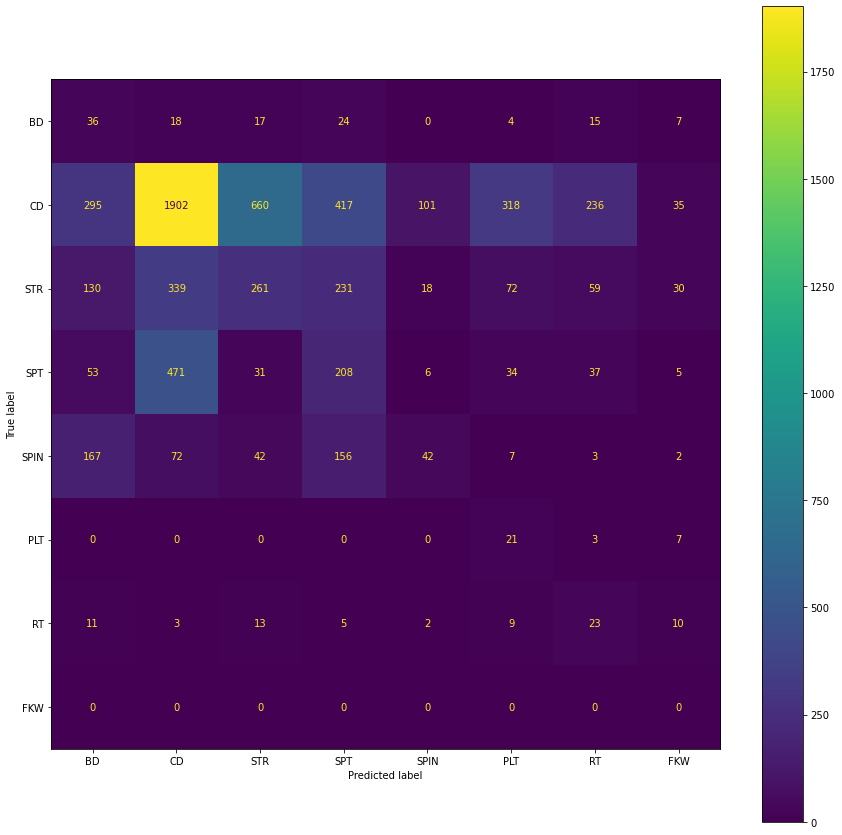

In [38]:
fig, ax = plt.subplots(figsize=[15, 15])
disp.plot(include_values=True,
                     cmap='viridis', ax=ax, xticks_rotation='horizontal',
                     values_format=None, colorbar=True)


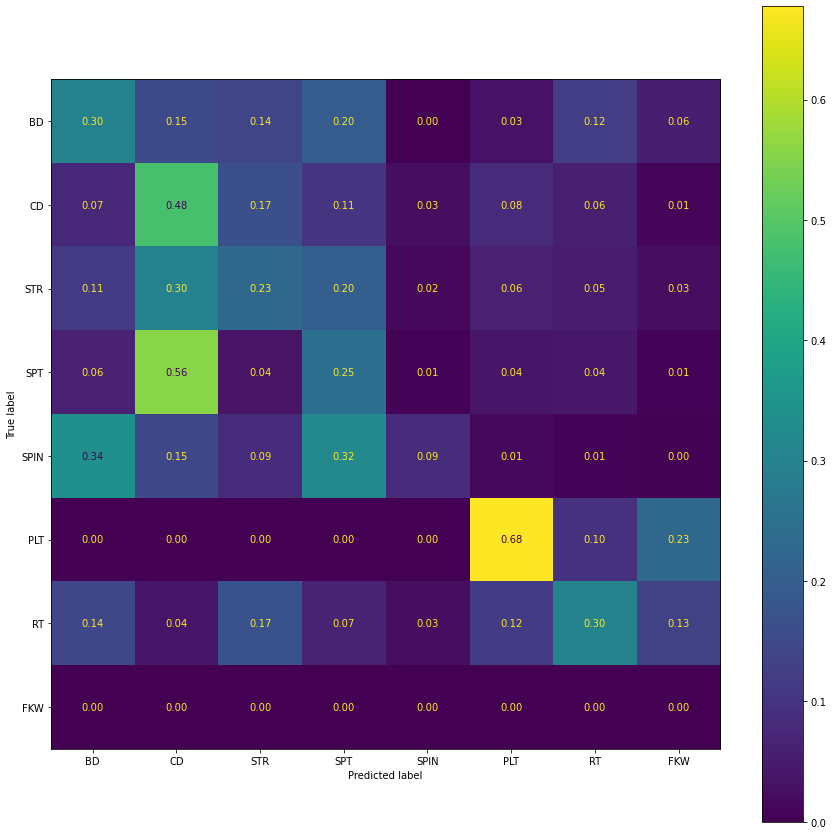

In [39]:
fig, ax = plt.subplots(figsize=[15, 15])
disp2.plot(include_values=True,
                     cmap='viridis', ax=ax, xticks_rotation='horizontal',
                     values_format='.2f', colorbar=True)

## STAR2003

In [40]:
ee = deployment[1]
print(ee)

STAR2003


In [41]:
# Training data
fea_temp = np.load(os.path.join(feature_path, 'train_oswald_no_'+ee+'.npz'))
fea_train = fea_temp['fea_train']
label_train_list = fea_temp['label_train']
del fea_temp

In [42]:
label_train = np.zeros(len(label_train_list))
for ii in range(len(label_train_list)):
    label_train[ii] = species_dict[label_train_list[ii]]

In [43]:
# Testing data
fea_temp = np.load(os.path.join(feature_path, 'oswald_'+ee+'_orig.npz'))
fea_test = fea_temp['feas_orig']
label_test_list = fea_temp['labels_orig']

fea_test = fea_test[:,:100,:]
label_test = np.zeros(len(label_test_list))
for ii in range(len(label_test_list)):
    label_test[ii] = species_dict[label_test_list[ii]]

In [44]:
fea_train = fea_train[:,:100,:]

In [45]:
label_train = np.zeros(len(label_train_list))
for ii in range(len(label_train_list)):
    label_train[ii] = species_dict[label_train_list[ii]]

In [46]:
Counter(label_train_list)

Counter({'BD': 10080,
         'CD': 23928,
         'PLT': 12042,
         'RT': 7866,
         'SPIN': 5904,
         'SPT': 11154,
         'STR': 14868,
         'FKW': 17460})

In [47]:
Counter(label_test.tolist())

Counter({0.0: 231, 1.0: 752, 7.0: 270, 4.0: 51, 3.0: 412, 2.0: 54})

In [48]:
fit_result_path2 = os.path.join(fit_result_path1, ee)
if not os.path.exists(fit_result_path2):
    makedirs(fit_result_path2)

In [49]:
print('feature train shape: '+str(fea_train.shape))
print('feature test shape: '+str(fea_test.shape))
print('label train shape: '+str(label_train.shape))
print('label test shape: '+str(label_test.shape))

dim_time = fea_train.shape[1]
dim_freq = fea_train.shape[2]
print('dim_time: '+str(dim_time))
print('dim_freq: '+str(dim_freq))

feature train shape: (103302, 100, 128)
feature test shape: (1770, 100, 128)
label train shape: (103302,)
label test shape: (1770,)
dim_time: 100
dim_freq: 128


In [50]:
# shuffle features & labels
fea_train, label_train = shuffle(fea_train, label_train, random_state=0)
fea_test, label_test = shuffle(fea_test, label_test, random_state=0)

In [51]:
# class weight
weights = compute_class_weight(class_weight='balanced', classes=np.unique(label_train), y=label_train)

class_weights = dict()
for ii in range(num_species):
    class_weights[ii] = weights[ii]

In [52]:
fea_train = np.expand_dims(fea_train, axis=3)
fea_test = np.expand_dims(fea_test, axis=3)

In [53]:
fea_train, fea_validate, label_train, label_validate = train_test_split(fea_train, label_train, test_size=0.30, random_state=42)

train_generator = DataGenerator(fea_train, label_train, batch_size=batch_size, num_classes=num_species)
del fea_train
validate_generator = DataGenerator(fea_validate, label_validate, batch_size=batch_size, num_classes=num_species)
del fea_validate

# test_generator = DataGenerator(fea_test, label_test, batch_size=batch_size, num_classes=num_species)


### Training the model

In [54]:
# model = model_cnn14_attention_multi(dim_time, dim_freq, num_species, model_type='feature_level_attention', conv_dim=conv_dim, pool_size=pool_size, pool_stride=pool_stride, hidden_units=hidden_units, l2_regu=l2_regu, drop_rate=drop_rate)
model = DenseNet121(include_top=True, weights=None, input_tensor=None, input_shape=(dim_time, dim_freq, 1), classes=num_species)
loss = CategoricalCrossentropy()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_fn), loss=loss, metrics=['accuracy'])

# With classes
# history = model.fit(fea_train, to_categorical(label_train), class_weight=class_weights, validation_split=0.3, batch_size=batch_size, epochs=num_epoch, callbacks=[EarlyStopping(patience=num_patience), ModelCheckpoint(filepath=os.path.join(fit_result_path, '{epoch:02d}-{val_loss:.4f}.hdf5'), verbose=1, monitor="val_loss", save_best_only=True)])
# history = model.fit(train_generator, validation_data=validate_generator, class_weight=class_weights, epochs=num_epoch, callbacks=[EarlyStopping(patience=num_patience, monitor='val_loss', mode='min', verbose=1), TensorBoard(log_dir=fit_result_path1), ModelCheckpoint(filepath=os.path.join(fit_result_path1, '{epoch:02d}-{val_loss:.4f}.hdf5'), verbose=1, monitor="val_loss", save_best_only=True)])
history = model.fit(train_generator, validation_data=validate_generator, class_weight=class_weights, epochs=num_epoch, callbacks=[EarlyStopping(patience=num_patience, monitor='val_loss', mode='min', verbose=1), TensorBoard(log_dir=fit_result_path2), ModelCheckpoint(filepath=os.path.join(fit_result_path2, 'epoch_{epoch:02d}_valloss_{val_loss:.4f}_valacc_{val_accuracy:.4f}.hdf5' ), verbose=1, monitor="val_loss", save_best_only=True)])

Epoch 1/200
2259/2259 [==============================] - ETA: 0s - loss: 2.0007 - accuracy: 0.2163
Epoch 00001: val_loss improved from inf to 1.82077, saving model to /home/ys587/__Data/__whistle/__whislte_30_species/__fit_result_species/20210222_120930/STAR2003/epoch_01_valloss_1.8208_valacc_0.2948.hdf5
2259/2259 [==============================] - 203s 90ms/step - loss: 2.0007 - accuracy: 0.2163 - val_loss: 1.8208 - val_accuracy: 0.2948
Epoch 2/200
2259/2259 [==============================] - ETA: 0s - loss: 1.7589 - accuracy: 0.3365
Epoch 00002: val_loss improved from 1.82077 to 1.65384, saving model to /home/ys587/__Data/__whistle/__whislte_30_species/__fit_result_species/20210222_120930/STAR2003/epoch_02_valloss_1.6538_valacc_0.3835.hdf5
2259/2259 [==============================] - 199s 88ms/step - loss: 1.7589 - accuracy: 0.3365 - val_loss: 1.6538 - val_accuracy: 0.3835
Epoch 3/200
2259/2259 [==============================] - ETA: 0s - loss: 1.6138 - accuracy: 0.4035
Epoch 00003: 

In [55]:
# fit_result_path1 = '/home/ys587/__Data/__whistle/__whislte_30_species/__fit_result_species/20210210_224527'
the_best_model, _ = find_best_model(fit_result_path2, purge=False)

Best model:1.3589
/home/ys587/__Data/__whistle/__whislte_30_species/__fit_result_species/20210222_120930/STAR2003/epoch_08_valloss_1.3589_valacc_0.4949.hdf5


In [56]:
model = load_model(the_best_model)
model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100, 128, 1) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 106, 134, 1)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 50, 64, 64)   3136        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 50, 64, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [57]:
label_pred = model.predict(fea_test)
# label_pred = model.predict(test_generator)

In [58]:
np.set_printoptions(linewidth=200, precision=2, suppress=True)

In [59]:
print("Confusion matrix:")
cm = confusion_matrix(label_test, np.argmax(label_pred, axis=1), labels=species_id)

print(species_list)
print('')
print(cm)
print('')

cm2 = cm*1.0
for ii in range(cm.shape[0]):
    cm_row = cm[ii, :]*1.0

    cm_row_sum = cm_row.sum()
    if cm_row_sum != 0:
        cm2[ii, :] = cm_row / cm_row_sum
    else:
        cm2[ii, :] = np.zeros(cm.shape[1])

print(cm2)

Confusion matrix:
['BD', 'CD', 'STR', 'SPT', 'SPIN', 'PLT', 'RT', 'FKW']

[[ 15   7 131  17  10   6  32  13]
 [ 13 294 209  93  11  16 105  11]
 [  1   1  35   1   3   0   8   5]
 [  6  27 164 172   3  19   9  12]
 [  5   2  15  12   9   0   5   3]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   2   0   0  15  38 215]]

[[0.06 0.03 0.57 0.07 0.04 0.03 0.14 0.06]
 [0.02 0.39 0.28 0.12 0.01 0.02 0.14 0.01]
 [0.02 0.02 0.65 0.02 0.06 0.   0.15 0.09]
 [0.01 0.07 0.4  0.42 0.01 0.05 0.02 0.03]
 [0.1  0.04 0.29 0.24 0.18 0.   0.1  0.06]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.01 0.   0.   0.06 0.14 0.8 ]]


In [60]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=species_list)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=species_list)

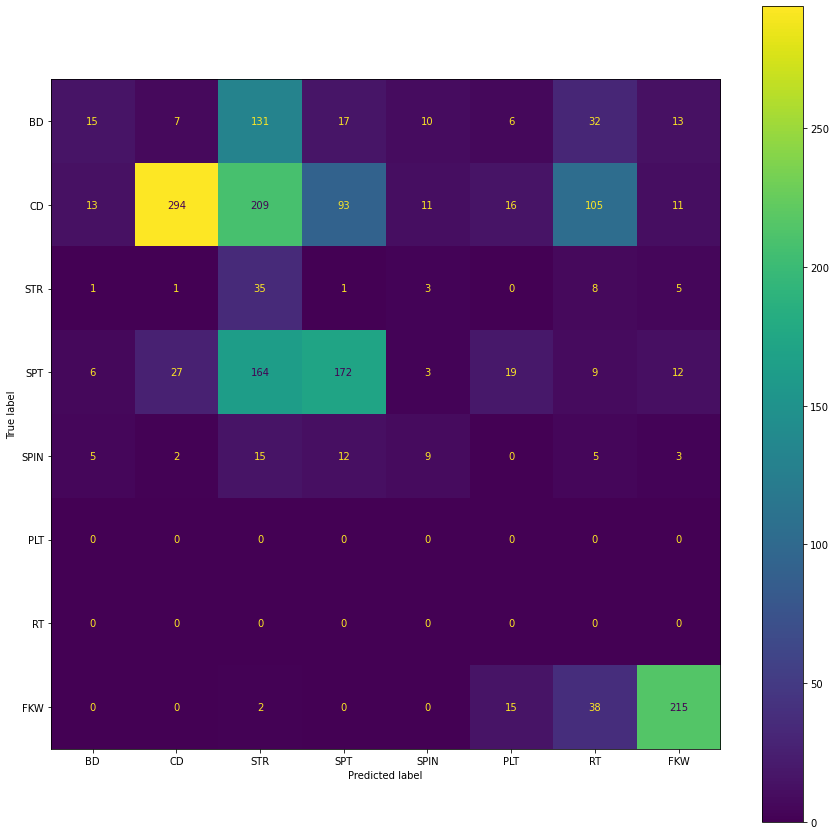

In [61]:
fig, ax = plt.subplots(figsize=[15, 15])
disp.plot(include_values=True,
                     cmap='viridis', ax=ax, xticks_rotation='horizontal',
                     values_format=None, colorbar=True)


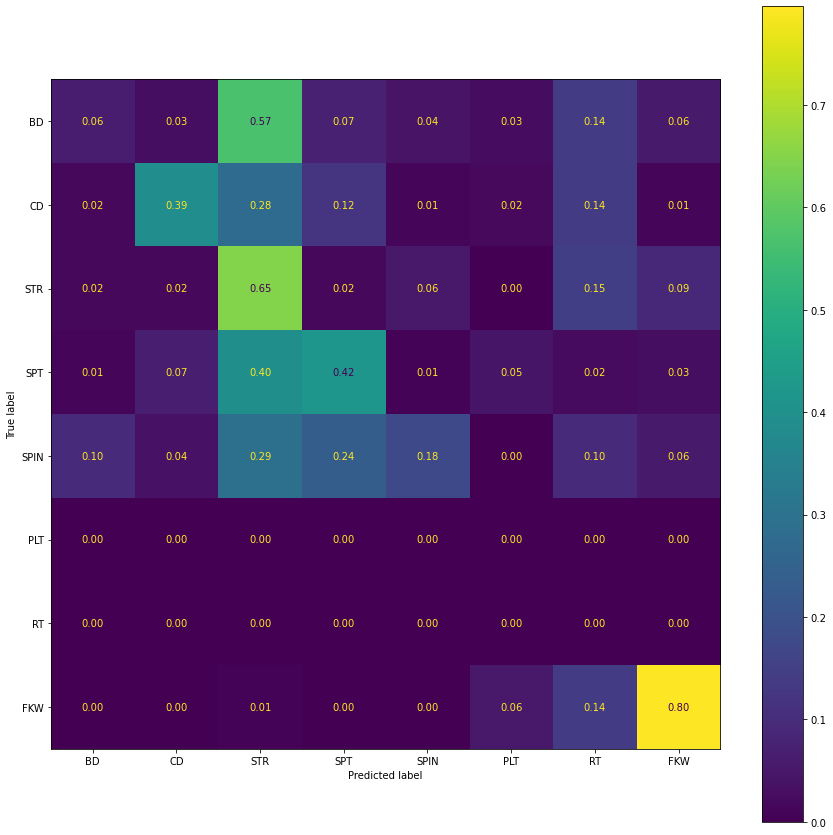

In [62]:
fig, ax = plt.subplots(figsize=[15, 15])
disp2.plot(include_values=True,
                     cmap='viridis', ax=ax, xticks_rotation='horizontal',
                     values_format='.2f', colorbar=True)

## STAR2006

In [63]:
ee = deployment[2]
print(ee)

STAR2006


In [64]:
# Training data
fea_temp = np.load(os.path.join(feature_path, 'train_oswald_no_'+ee+'.npz'))
fea_train = fea_temp['fea_train']
label_train_list = fea_temp['label_train']
del fea_temp

In [65]:
label_train = np.zeros(len(label_train_list))
for ii in range(len(label_train_list)):
    label_train[ii] = species_dict[label_train_list[ii]]

In [66]:
# Testing data
fea_temp = np.load(os.path.join(feature_path, 'oswald_'+ee+'_orig.npz'))
fea_test = fea_temp['feas_orig']
label_test_list = fea_temp['labels_orig']

fea_test = fea_test[:,:100,:]
label_test = np.zeros(len(label_test_list))
for ii in range(len(label_test_list)):
    label_test[ii] = species_dict[label_test_list[ii]]

In [67]:
fea_train = fea_train[:,:100,:]

In [68]:
label_train = np.zeros(len(label_train_list))
for ii in range(len(label_train_list)):
    label_train[ii] = species_dict[label_train_list[ii]]

In [69]:
Counter(label_train_list)

Counter({'BD': 11466,
         'CD': 28296,
         'PLT': 8250,
         'RT': 7590,
         'SPIN': 6198,
         'SPT': 12744,
         'STR': 10692,
         'FKW': 13662})

In [70]:
Counter(label_test.tolist())

Counter({1.0: 24, 7.0: 903, 5.0: 632, 6.0: 46, 4.0: 2, 3.0: 147, 2.0: 750})

In [71]:
fit_result_path2 = os.path.join(fit_result_path1, ee)
if not os.path.exists(fit_result_path2):
    makedirs(fit_result_path2)

In [72]:
print('feature train shape: '+str(fea_train.shape))
print('feature test shape: '+str(fea_test.shape))
print('label train shape: '+str(label_train.shape))
print('label test shape: '+str(label_test.shape))

dim_time = fea_train.shape[1]
dim_freq = fea_train.shape[2]
print('dim_time: '+str(dim_time))
print('dim_freq: '+str(dim_freq))

feature train shape: (98898, 100, 128)
feature test shape: (2504, 100, 128)
label train shape: (98898,)
label test shape: (2504,)
dim_time: 100
dim_freq: 128


In [73]:
# shuffle features & labels
fea_train, label_train = shuffle(fea_train, label_train, random_state=0)
fea_test, label_test = shuffle(fea_test, label_test, random_state=0)

In [74]:
# class weight
weights = compute_class_weight(class_weight='balanced', classes=np.unique(label_train), y=label_train)

class_weights = dict()
for ii in range(num_species):
    class_weights[ii] = weights[ii]

In [75]:
fea_train = np.expand_dims(fea_train, axis=3)
fea_test = np.expand_dims(fea_test, axis=3)

In [76]:
fea_train, fea_validate, label_train, label_validate = train_test_split(fea_train, label_train, test_size=0.30, random_state=42)

train_generator = DataGenerator(fea_train, label_train, batch_size=batch_size, num_classes=num_species)
del fea_train
validate_generator = DataGenerator(fea_validate, label_validate, batch_size=batch_size, num_classes=num_species)
del fea_validate

# test_generator = DataGenerator(fea_test, label_test, batch_size=batch_size, num_classes=num_species)


### Training the model

In [77]:
# model = model_cnn14_attention_multi(dim_time, dim_freq, num_species, model_type='feature_level_attention', conv_dim=conv_dim, pool_size=pool_size, pool_stride=pool_stride, hidden_units=hidden_units, l2_regu=l2_regu, drop_rate=drop_rate)
model = DenseNet121(include_top=True, weights=None, input_tensor=None, input_shape=(dim_time, dim_freq, 1), classes=num_species)
loss = CategoricalCrossentropy()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_fn), loss=loss, metrics=['accuracy'])

# With classes
# history = model.fit(fea_train, to_categorical(label_train), class_weight=class_weights, validation_split=0.3, batch_size=batch_size, epochs=num_epoch, callbacks=[EarlyStopping(patience=num_patience), ModelCheckpoint(filepath=os.path.join(fit_result_path, '{epoch:02d}-{val_loss:.4f}.hdf5'), verbose=1, monitor="val_loss", save_best_only=True)])
# history = model.fit(train_generator, validation_data=validate_generator, class_weight=class_weights, epochs=num_epoch, callbacks=[EarlyStopping(patience=num_patience, monitor='val_loss', mode='min', verbose=1), TensorBoard(log_dir=fit_result_path1), ModelCheckpoint(filepath=os.path.join(fit_result_path1, '{epoch:02d}-{val_loss:.4f}.hdf5'), verbose=1, monitor="val_loss", save_best_only=True)])
history = model.fit(train_generator, validation_data=validate_generator, class_weight=class_weights, epochs=num_epoch, callbacks=[EarlyStopping(patience=num_patience, monitor='val_loss', mode='min', verbose=1), TensorBoard(log_dir=fit_result_path2), ModelCheckpoint(filepath=os.path.join(fit_result_path2, 'epoch_{epoch:02d}_valloss_{val_loss:.4f}_valacc_{val_accuracy:.4f}.hdf5' ), verbose=1, monitor="val_loss", save_best_only=True)])

Epoch 1/200
2163/2163 [==============================] - ETA: 0s - loss: 2.0228 - accuracy: 0.2296
Epoch 00001: val_loss improved from inf to 1.89148, saving model to /home/ys587/__Data/__whistle/__whislte_30_species/__fit_result_species/20210222_120930/STAR2006/epoch_01_valloss_1.8915_valacc_0.2964.hdf5
2163/2163 [==============================] - 203s 94ms/step - loss: 2.0228 - accuracy: 0.2296 - val_loss: 1.8915 - val_accuracy: 0.2964
Epoch 2/200
2163/2163 [==============================] - ETA: 0s - loss: 1.7654 - accuracy: 0.3296
Epoch 00002: val_loss improved from 1.89148 to 1.63943, saving model to /home/ys587/__Data/__whistle/__whislte_30_species/__fit_result_species/20210222_120930/STAR2006/epoch_02_valloss_1.6394_valacc_0.3688.hdf5
2163/2163 [==============================] - 202s 93ms/step - loss: 1.7654 - accuracy: 0.3296 - val_loss: 1.6394 - val_accuracy: 0.3688
Epoch 3/200
2163/2163 [==============================] - ETA: 0s - loss: 1.6023 - accuracy: 0.3960
Epoch 00003: 

In [78]:
# fit_result_path1 = '/home/ys587/__Data/__whistle/__whislte_30_species/__fit_result_species/20210210_224527'
the_best_model, _ = find_best_model(fit_result_path2, purge=False)

Best model:1.4099
/home/ys587/__Data/__whistle/__whislte_30_species/__fit_result_species/20210222_120930/STAR2006/epoch_09_valloss_1.4099_valacc_0.4737.hdf5


In [79]:
model = load_model(the_best_model)
model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 100, 128, 1) 0                                            
__________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D (None, 106, 134, 1)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 50, 64, 64)   3136        zero_padding2d_4[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 50, 64, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [80]:
label_pred = model.predict(fea_test)
# label_pred = model.predict(test_generator)

In [81]:
np.set_printoptions(linewidth=200, precision=2, suppress=True)

In [82]:
print("Confusion matrix:")
cm = confusion_matrix(label_test, np.argmax(label_pred, axis=1), labels=species_id)

print(species_list)
print('')
print(cm)
print('')

cm2 = cm*1.0
for ii in range(cm.shape[0]):
    cm_row = cm[ii, :]*1.0

    cm_row_sum = cm_row.sum()
    if cm_row_sum != 0:
        cm2[ii, :] = cm_row / cm_row_sum
    else:
        cm2[ii, :] = np.zeros(cm.shape[1])

print(cm2)

Confusion matrix:
['BD', 'CD', 'STR', 'SPT', 'SPIN', 'PLT', 'RT', 'FKW']

[[  0   0   0   0   0   0   0   0]
 [  3   1   4   2   8   1   4   1]
 [179  14 276 116 111  10  29  15]
 [131   0   1   3  12   0   0   0]
 [  0   0   0   1   0   0   1   0]
 [217  27  27   6  39 223  57  36]
 [ 15   0   2   1   3   2  20   3]
 [ 19  16  18  12   1  91  53 693]]

[[0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.12 0.04 0.17 0.08 0.33 0.04 0.17 0.04]
 [0.24 0.02 0.37 0.15 0.15 0.01 0.04 0.02]
 [0.89 0.   0.01 0.02 0.08 0.   0.   0.  ]
 [0.   0.   0.   0.5  0.   0.   0.5  0.  ]
 [0.34 0.04 0.04 0.01 0.06 0.35 0.09 0.06]
 [0.33 0.   0.04 0.02 0.07 0.04 0.43 0.07]
 [0.02 0.02 0.02 0.01 0.   0.1  0.06 0.77]]


In [83]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=species_list)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=species_list)

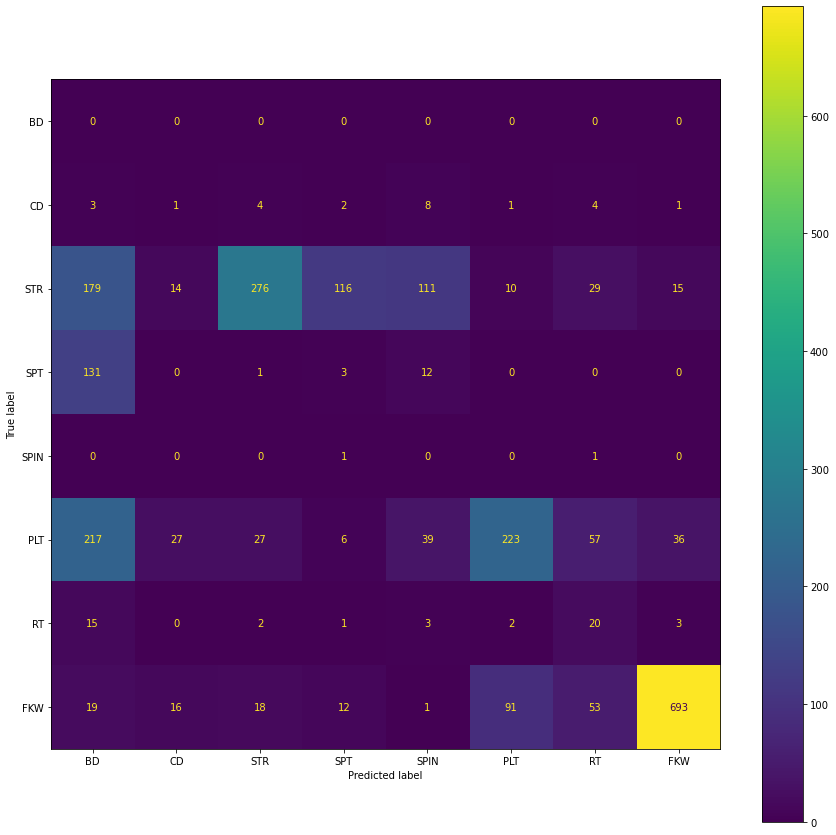

In [84]:
fig, ax = plt.subplots(figsize=[15, 15])
disp.plot(include_values=True,
                     cmap='viridis', ax=ax, xticks_rotation='horizontal',
                     values_format=None, colorbar=True)


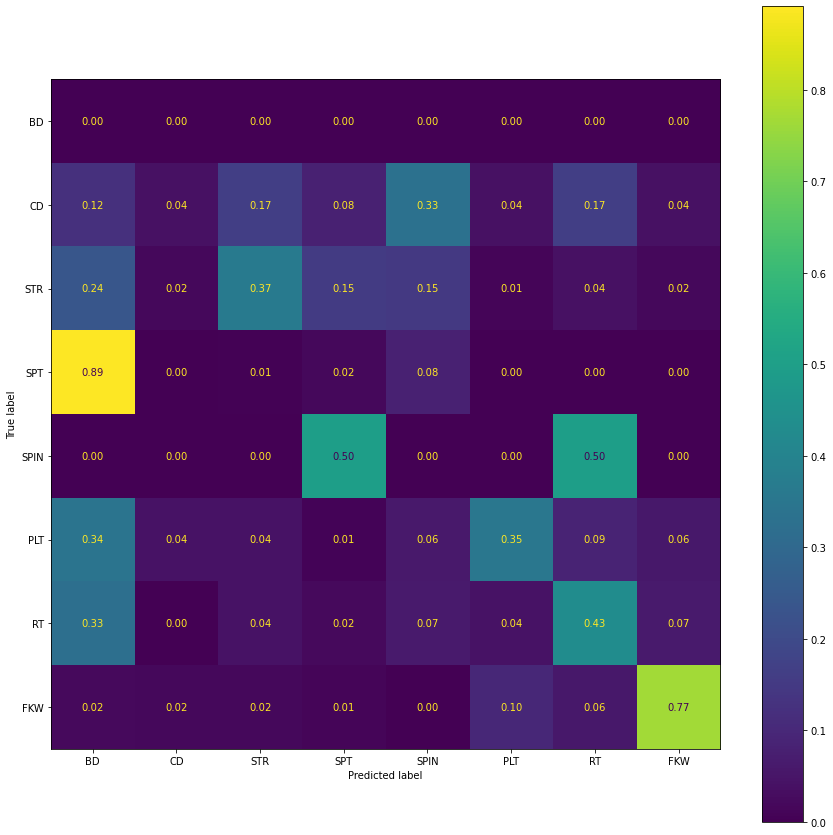

In [85]:
fig, ax = plt.subplots(figsize=[15, 15])
disp2.plot(include_values=True,
                     cmap='viridis', ax=ax, xticks_rotation='horizontal',
                     values_format='.2f', colorbar=True)

## HICEAS2002

In [86]:
ee = deployment[3]
print(ee)

HICEAS2002


In [87]:
# Training data
fea_temp = np.load(os.path.join(feature_path, 'train_oswald_no_'+ee+'.npz'))
fea_train = fea_temp['fea_train']
label_train_list = fea_temp['label_train']
del fea_temp

In [88]:
label_train = np.zeros(len(label_train_list))
for ii in range(len(label_train_list)):
    label_train[ii] = species_dict[label_train_list[ii]]

In [89]:
# Testing data
fea_temp = np.load(os.path.join(feature_path, 'oswald_'+ee+'_orig.npz'))
fea_test = fea_temp['feas_orig']
label_test_list = fea_temp['labels_orig']

fea_test = fea_test[:,:100,:]
label_test = np.zeros(len(label_test_list))
for ii in range(len(label_test_list)):
    label_test[ii] = species_dict[label_test_list[ii]]

In [90]:
fea_train = fea_train[:,:100,:]

In [91]:
label_train = np.zeros(len(label_train_list))
for ii in range(len(label_train_list)):
    label_train[ii] = species_dict[label_train_list[ii]]

In [92]:
Counter(label_train_list)

Counter({'BD': 11220,
         'CD': 28440,
         'PLT': 5730,
         'RT': 3372,
         'SPIN': 5694,
         'SPT': 11316,
         'STR': 13896,
         'FKW': 19080})

In [93]:
Counter(label_test.tolist())

Counter({0.0: 41, 5.0: 1052, 6.0: 749, 4.0: 86, 3.0: 385, 2.0: 216})

In [94]:
fit_result_path2 = os.path.join(fit_result_path1, ee)
if not os.path.exists(fit_result_path2):
    makedirs(fit_result_path2)

In [95]:
print('feature train shape: '+str(fea_train.shape))
print('feature test shape: '+str(fea_test.shape))
print('label train shape: '+str(label_train.shape))
print('label test shape: '+str(label_test.shape))

dim_time = fea_train.shape[1]
dim_freq = fea_train.shape[2]
print('dim_time: '+str(dim_time))
print('dim_freq: '+str(dim_freq))

feature train shape: (98748, 100, 128)
feature test shape: (2529, 100, 128)
label train shape: (98748,)
label test shape: (2529,)
dim_time: 100
dim_freq: 128


In [96]:
# shuffle features & labels
fea_train, label_train = shuffle(fea_train, label_train, random_state=0)
fea_test, label_test = shuffle(fea_test, label_test, random_state=0)

In [97]:
# class weight
weights = compute_class_weight(class_weight='balanced', classes=np.unique(label_train), y=label_train)

class_weights = dict()
for ii in range(num_species):
    class_weights[ii] = weights[ii]

In [98]:
fea_train = np.expand_dims(fea_train, axis=3)
fea_test = np.expand_dims(fea_test, axis=3)

In [99]:
fea_train, fea_validate, label_train, label_validate = train_test_split(fea_train, label_train, test_size=0.30, random_state=42)

train_generator = DataGenerator(fea_train, label_train, batch_size=batch_size, num_classes=num_species)
del fea_train
validate_generator = DataGenerator(fea_validate, label_validate, batch_size=batch_size, num_classes=num_species)
del fea_validate

# test_generator = DataGenerator(fea_test, label_test, batch_size=batch_size, num_classes=num_species)


### Training the model

In [100]:
# model = model_cnn14_attention_multi(dim_time, dim_freq, num_species, model_type='feature_level_attention', conv_dim=conv_dim, pool_size=pool_size, pool_stride=pool_stride, hidden_units=hidden_units, l2_regu=l2_regu, drop_rate=drop_rate)
model = DenseNet121(include_top=True, weights=None, input_tensor=None, input_shape=(dim_time, dim_freq, 1), classes=num_species)
loss = CategoricalCrossentropy()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_fn), loss=loss, metrics=['accuracy'])

# With classes
# history = model.fit(fea_train, to_categorical(label_train), class_weight=class_weights, validation_split=0.3, batch_size=batch_size, epochs=num_epoch, callbacks=[EarlyStopping(patience=num_patience), ModelCheckpoint(filepath=os.path.join(fit_result_path, '{epoch:02d}-{val_loss:.4f}.hdf5'), verbose=1, monitor="val_loss", save_best_only=True)])
# history = model.fit(train_generator, validation_data=validate_generator, class_weight=class_weights, epochs=num_epoch, callbacks=[EarlyStopping(patience=num_patience, monitor='val_loss', mode='min', verbose=1), TensorBoard(log_dir=fit_result_path1), ModelCheckpoint(filepath=os.path.join(fit_result_path1, '{epoch:02d}-{val_loss:.4f}.hdf5'), verbose=1, monitor="val_loss", save_best_only=True)])
history = model.fit(train_generator, validation_data=validate_generator, class_weight=class_weights, epochs=num_epoch, callbacks=[EarlyStopping(patience=num_patience, monitor='val_loss', mode='min', verbose=1), TensorBoard(log_dir=fit_result_path2), ModelCheckpoint(filepath=os.path.join(fit_result_path2, 'epoch_{epoch:02d}_valloss_{val_loss:.4f}_valacc_{val_accuracy:.4f}.hdf5' ), verbose=1, monitor="val_loss", save_best_only=True)])

Epoch 1/200
2160/2160 [==============================] - ETA: 0s - loss: 1.9919 - accuracy: 0.2136
Epoch 00001: val_loss improved from inf to 1.86517, saving model to /home/ys587/__Data/__whistle/__whislte_30_species/__fit_result_species/20210222_120930/HICEAS2002/epoch_01_valloss_1.8652_valacc_0.2788.hdf5
2160/2160 [==============================] - 193s 89ms/step - loss: 1.9919 - accuracy: 0.2136 - val_loss: 1.8652 - val_accuracy: 0.2788
Epoch 2/200
2160/2160 [==============================] - ETA: 0s - loss: 1.7279 - accuracy: 0.3396
Epoch 00002: val_loss improved from 1.86517 to 1.57873, saving model to /home/ys587/__Data/__whistle/__whislte_30_species/__fit_result_species/20210222_120930/HICEAS2002/epoch_02_valloss_1.5787_valacc_0.3980.hdf5
2160/2160 [==============================] - 190s 88ms/step - loss: 1.7279 - accuracy: 0.3396 - val_loss: 1.5787 - val_accuracy: 0.3980
Epoch 3/200
2160/2160 [==============================] - ETA: 0s - loss: 1.5909 - accuracy: 0.3953
Epoch 000

In [101]:
# fit_result_path1 = '/home/ys587/__Data/__whistle/__whislte_30_species/__fit_result_species/20210210_224527'
the_best_model, _ = find_best_model(fit_result_path2, purge=False)

Best model:1.3192
/home/ys587/__Data/__whistle/__whislte_30_species/__fit_result_species/20210222_120930/HICEAS2002/epoch_10_valloss_1.3192_valacc_0.5055.hdf5


In [102]:
model = load_model(the_best_model)
model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 100, 128, 1) 0                                            
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 106, 134, 1)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 50, 64, 64)   3136        zero_padding2d_6[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 50, 64, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [103]:
label_pred = model.predict(fea_test)
# label_pred = model.predict(test_generator)

In [104]:
np.set_printoptions(linewidth=200, precision=2, suppress=True)

In [105]:
print("Confusion matrix:")
cm = confusion_matrix(label_test, np.argmax(label_pred, axis=1), labels=species_id)

print(species_list)
print('')
print(cm)
print('')

cm2 = cm*1.0
for ii in range(cm.shape[0]):
    cm_row = cm[ii, :]*1.0

    cm_row_sum = cm_row.sum()
    if cm_row_sum != 0:
        cm2[ii, :] = cm_row / cm_row_sum
    else:
        cm2[ii, :] = np.zeros(cm.shape[1])

print(cm2)

Confusion matrix:
['BD', 'CD', 'STR', 'SPT', 'SPIN', 'PLT', 'RT', 'FKW']

[[  9   0   3   2   1   8   8  10]
 [  0   0   0   0   0   0   0   0]
 [  9  34 115  23  12   0  11  12]
 [ 48  19  84 141  85   1   0   7]
 [  0  12   7   3   0   6  20  38]
 [  3 102  86 106  13 445  19 278]
 [  1  97  94  12  15  33 263 234]
 [  0   0   0   0   0   0   0   0]]

[[0.22 0.   0.07 0.05 0.02 0.2  0.2  0.24]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.04 0.16 0.53 0.11 0.06 0.   0.05 0.06]
 [0.12 0.05 0.22 0.37 0.22 0.   0.   0.02]
 [0.   0.14 0.08 0.03 0.   0.07 0.23 0.44]
 [0.   0.1  0.08 0.1  0.01 0.42 0.02 0.26]
 [0.   0.13 0.13 0.02 0.02 0.04 0.35 0.31]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]]


In [106]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=species_list)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=species_list)

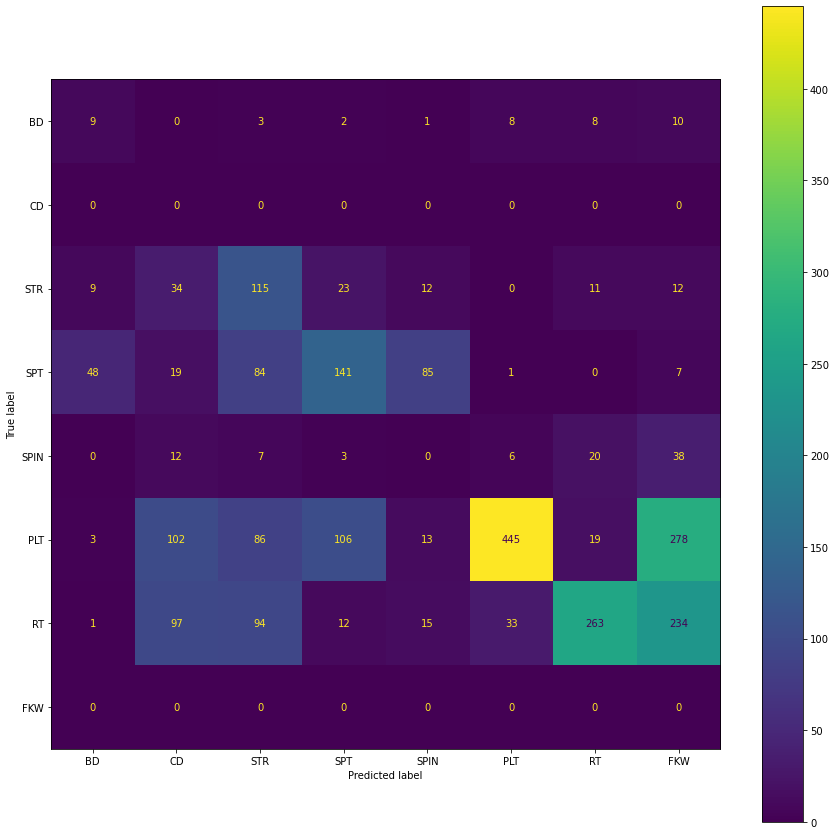

In [107]:
fig, ax = plt.subplots(figsize=[15, 15])
disp.plot(include_values=True,
                     cmap='viridis', ax=ax, xticks_rotation='horizontal',
                     values_format=None, colorbar=True)


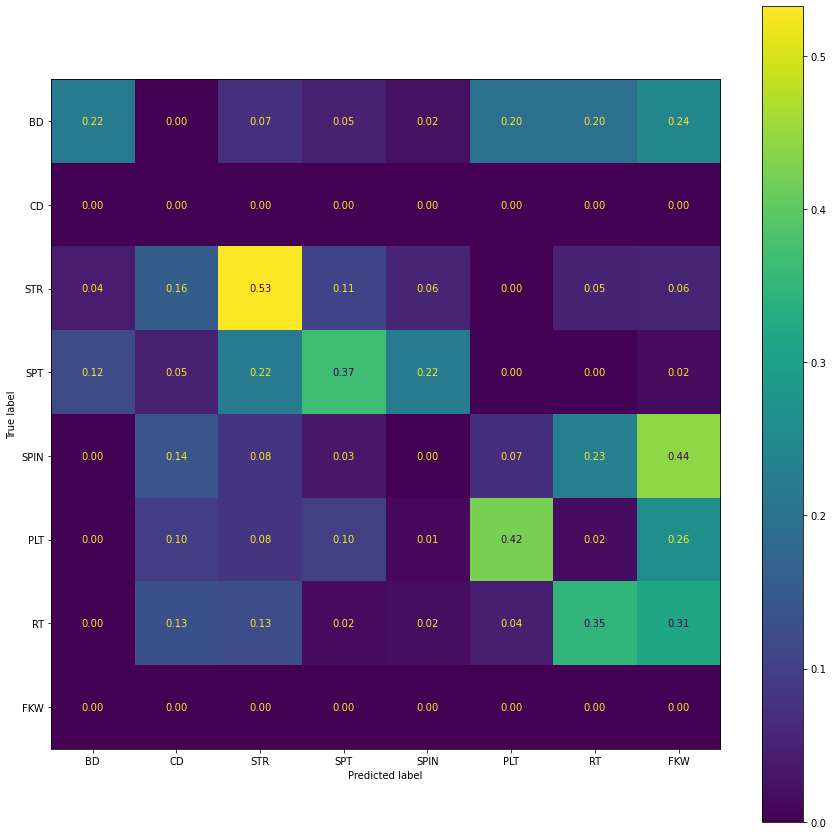

In [108]:
fig, ax = plt.subplots(figsize=[15, 15])
disp2.plot(include_values=True,
                     cmap='viridis', ax=ax, xticks_rotation='horizontal',
                     values_format='.2f', colorbar=True)

## PICES2005

In [109]:
ee = deployment[4]
print(ee)

PICEAS2005


In [110]:
# Training data
fea_temp = np.load(os.path.join(feature_path, 'train_oswald_no_'+ee+'.npz'))
fea_train = fea_temp['fea_train']
label_train_list = fea_temp['label_train']
del fea_temp

In [111]:
label_train = np.zeros(len(label_train_list))
for ii in range(len(label_train_list)):
    label_train[ii] = species_dict[label_train_list[ii]]

In [112]:
# Testing data
fea_temp = np.load(os.path.join(feature_path, 'oswald_'+ee+'_orig.npz'))
fea_test = fea_temp['feas_orig']
label_test_list = fea_temp['labels_orig']

fea_test = fea_test[:,:100,:]
label_test = np.zeros(len(label_test_list))
for ii in range(len(label_test_list)):
    label_test[ii] = species_dict[label_test_list[ii]]

In [113]:
fea_train = fea_train[:,:100,:]

In [114]:
label_train = np.zeros(len(label_train_list))
for ii in range(len(label_train_list)):
    label_train[ii] = species_dict[label_train_list[ii]]

In [115]:
Counter(label_train_list)

Counter({'BD': 2358,
         'CD': 28440,
         'PLT': 10290,
         'RT': 5226,
         'SPIN': 3780,
         'SPT': 10734,
         'STR': 12960,
         'FKW': 7038})

In [116]:
Counter(label_test.tolist())

Counter({0.0: 1518,
         7.0: 2007,
         5.0: 292,
         6.0: 440,
         4.0: 405,
         3.0: 482,
         2.0: 372})

In [117]:
fit_result_path2 = os.path.join(fit_result_path1, ee)
if not os.path.exists(fit_result_path2):
    makedirs(fit_result_path2)

In [118]:
print('feature train shape: '+str(fea_train.shape))
print('feature test shape: '+str(fea_test.shape))
print('label train shape: '+str(label_train.shape))
print('label test shape: '+str(label_test.shape))

dim_time = fea_train.shape[1]
dim_freq = fea_train.shape[2]
print('dim_time: '+str(dim_time))
print('dim_freq: '+str(dim_freq))

feature train shape: (80826, 100, 128)
feature test shape: (5516, 100, 128)
label train shape: (80826,)
label test shape: (5516,)
dim_time: 100
dim_freq: 128


In [119]:
# shuffle features & labels
fea_train, label_train = shuffle(fea_train, label_train, random_state=0)
fea_test, label_test = shuffle(fea_test, label_test, random_state=0)

In [120]:
# class weight
weights = compute_class_weight(class_weight='balanced', classes=np.unique(label_train), y=label_train)

class_weights = dict()
for ii in range(num_species):
    class_weights[ii] = weights[ii]

In [121]:
fea_train = np.expand_dims(fea_train, axis=3)
fea_test = np.expand_dims(fea_test, axis=3)

In [122]:
fea_train, fea_validate, label_train, label_validate = train_test_split(fea_train, label_train, test_size=0.30, random_state=42)

train_generator = DataGenerator(fea_train, label_train, batch_size=batch_size, num_classes=num_species)
del fea_train
validate_generator = DataGenerator(fea_validate, label_validate, batch_size=batch_size, num_classes=num_species)
del fea_validate

# test_generator = DataGenerator(fea_test, label_test, batch_size=batch_size, num_classes=num_species)


### Training the model

In [123]:
# model = model_cnn14_attention_multi(dim_time, dim_freq, num_species, model_type='feature_level_attention', conv_dim=conv_dim, pool_size=pool_size, pool_stride=pool_stride, hidden_units=hidden_units, l2_regu=l2_regu, drop_rate=drop_rate)
model = DenseNet121(include_top=True, weights=None, input_tensor=None, input_shape=(dim_time, dim_freq, 1), classes=num_species)
loss = CategoricalCrossentropy()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_fn), loss=loss, metrics=['accuracy'])

# With classes
# history = model.fit(fea_train, to_categorical(label_train), class_weight=class_weights, validation_split=0.3, batch_size=batch_size, epochs=num_epoch, callbacks=[EarlyStopping(patience=num_patience), ModelCheckpoint(filepath=os.path.join(fit_result_path, '{epoch:02d}-{val_loss:.4f}.hdf5'), verbose=1, monitor="val_loss", save_best_only=True)])
# history = model.fit(train_generator, validation_data=validate_generator, class_weight=class_weights, epochs=num_epoch, callbacks=[EarlyStopping(patience=num_patience, monitor='val_loss', mode='min', verbose=1), TensorBoard(log_dir=fit_result_path1), ModelCheckpoint(filepath=os.path.join(fit_result_path1, '{epoch:02d}-{val_loss:.4f}.hdf5'), verbose=1, monitor="val_loss", save_best_only=True)])
history = model.fit(train_generator, validation_data=validate_generator, class_weight=class_weights, epochs=num_epoch, callbacks=[EarlyStopping(patience=num_patience, monitor='val_loss', mode='min', verbose=1), TensorBoard(log_dir=fit_result_path2), ModelCheckpoint(filepath=os.path.join(fit_result_path2, 'epoch_{epoch:02d}_valloss_{val_loss:.4f}_valacc_{val_accuracy:.4f}.hdf5' ), verbose=1, monitor="val_loss", save_best_only=True)])

Epoch 1/200
1768/1768 [==============================] - ETA: 0s - loss: 2.0268 - accuracy: 0.1829
Epoch 00001: val_loss improved from inf to 1.91085, saving model to /home/ys587/__Data/__whistle/__whislte_30_species/__fit_result_species/20210222_120930/PICEAS2005/epoch_01_valloss_1.9108_valacc_0.2638.hdf5
1768/1768 [==============================] - 157s 89ms/step - loss: 2.0268 - accuracy: 0.1829 - val_loss: 1.9108 - val_accuracy: 0.2638
Epoch 2/200
1768/1768 [==============================] - ETA: 0s - loss: 1.7946 - accuracy: 0.2902
Epoch 00002: val_loss improved from 1.91085 to 1.68088, saving model to /home/ys587/__Data/__whistle/__whislte_30_species/__fit_result_species/20210222_120930/PICEAS2005/epoch_02_valloss_1.6809_valacc_0.3527.hdf5
1768/1768 [==============================] - 153s 87ms/step - loss: 1.7946 - accuracy: 0.2902 - val_loss: 1.6809 - val_accuracy: 0.3527
Epoch 3/200
1768/1768 [==============================] - ETA: 0s - loss: 1.6116 - accuracy: 0.3779
Epoch 000

In [124]:
# fit_result_path1 = '/home/ys587/__Data/__whistle/__whislte_30_species/__fit_result_species/20210210_224527'
the_best_model, _ = find_best_model(fit_result_path2, purge=False)

Best model:1.356
/home/ys587/__Data/__whistle/__whislte_30_species/__fit_result_species/20210222_120930/PICEAS2005/epoch_10_valloss_1.3560_valacc_0.4948.hdf5


In [125]:
model = load_model(the_best_model)
model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 100, 128, 1) 0                                            
__________________________________________________________________________________________________
zero_padding2d_8 (ZeroPadding2D (None, 106, 134, 1)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 50, 64, 64)   3136        zero_padding2d_8[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 50, 64, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [126]:
label_pred = model.predict(fea_test)
# label_pred = model.predict(test_generator)

In [127]:
np.set_printoptions(linewidth=200, precision=2, suppress=True)

In [128]:
print("Confusion matrix:")
cm = confusion_matrix(label_test, np.argmax(label_pred, axis=1), labels=species_id)

print(species_list)
print('')
print(cm)
print('')

cm2 = cm*1.0
for ii in range(cm.shape[0]):
    cm_row = cm[ii, :]*1.0

    cm_row_sum = cm_row.sum()
    if cm_row_sum != 0:
        cm2[ii, :] = cm_row / cm_row_sum
    else:
        cm2[ii, :] = np.zeros(cm.shape[1])

print(cm2)

Confusion matrix:
['BD', 'CD', 'STR', 'SPT', 'SPIN', 'PLT', 'RT', 'FKW']

[[148 250 150 257 621  61  26   5]
 [  0   0   0   0   0   0   0   0]
 [ 45  44 118  36 109  12   6   2]
 [ 54   9  52  94 260  11   2   0]
 [ 33  18  54  15 272   8   4   1]
 [ 22  30   7   6  21 178  16  12]
 [ 61  35  24  13  21  78 181  27]
 [174  68  67  50  50 419 477 702]]

[[0.1  0.16 0.1  0.17 0.41 0.04 0.02 0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.12 0.12 0.32 0.1  0.29 0.03 0.02 0.01]
 [0.11 0.02 0.11 0.2  0.54 0.02 0.   0.  ]
 [0.08 0.04 0.13 0.04 0.67 0.02 0.01 0.  ]
 [0.08 0.1  0.02 0.02 0.07 0.61 0.05 0.04]
 [0.14 0.08 0.05 0.03 0.05 0.18 0.41 0.06]
 [0.09 0.03 0.03 0.02 0.02 0.21 0.24 0.35]]


In [129]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=species_list)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=species_list)

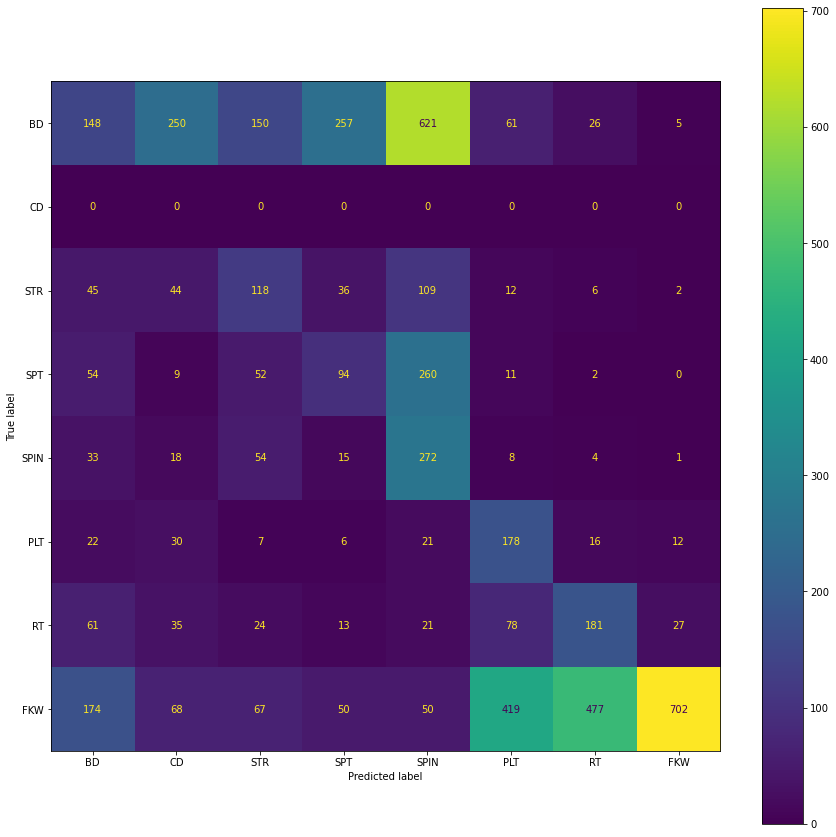

In [130]:
fig, ax = plt.subplots(figsize=[15, 15])
disp.plot(include_values=True,
                     cmap='viridis', ax=ax, xticks_rotation='horizontal',
                     values_format=None, colorbar=True)


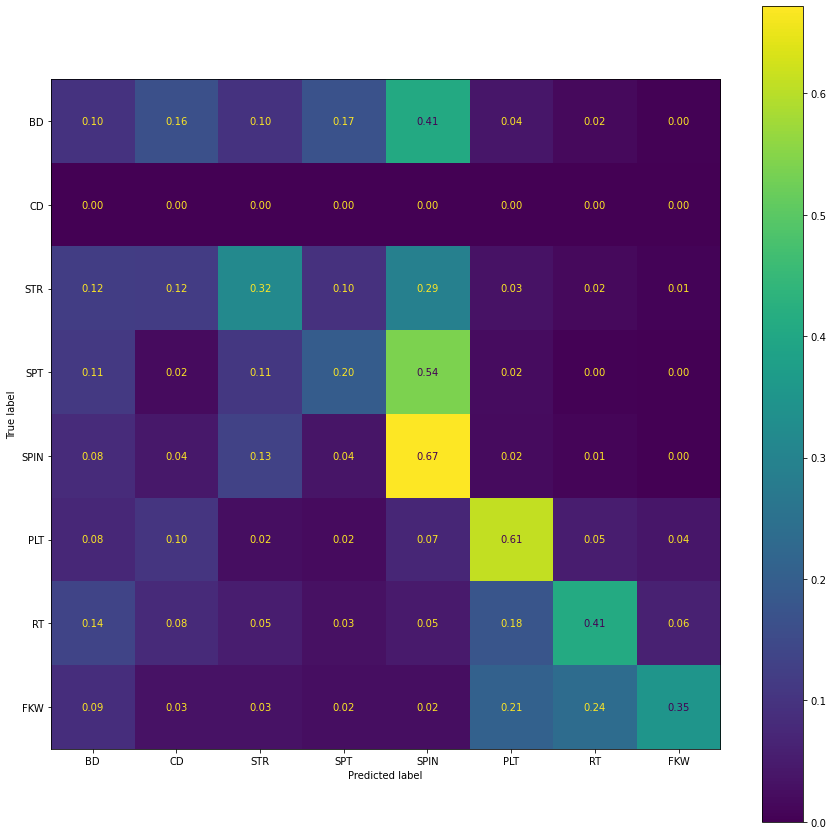

In [131]:
fig, ax = plt.subplots(figsize=[15, 15])
disp2.plot(include_values=True,
                     cmap='viridis', ax=ax, xticks_rotation='horizontal',
                     values_format='.2f', colorbar=True)